Load libraries and data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

train=np.loadtxt('sincTrain25.dt')
trainx=train[:,0]
trainy=train[:,1]
valid=np.loadtxt('sincValidate10.dt')
valx=valid[:,0]
valy=valid[:,1]

Let's plot the training data and validation data (they are generated from the function sinc(x)=sin(x)/x)so we have an idea of what it looks like.

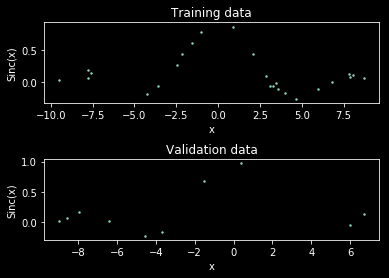

In [2]:
%matplotlib inline
plt.style.use("dark_background")
fig, ax = plt.subplots(2)
fig.subplots_adjust(hspace=0.7)
ax[0].scatter(trainx, trainy, s=2)
ax[0].set_title('Training data')
ax[0].set_ylabel('Sinc(x)')
ax[0].set_xlabel('x')
ax[1].scatter(valx, valy, s=2)
ax[1].set_title('Validation data')
ax[1].set_ylabel('Sinc(x)')
ax[1].set_xlabel('x')
plt.show()

Define neural network function and gradient descent function

In [3]:
def neural_network(x, w, activation_function, has_ones = False):
    w0 = w[0]
    w1 = w[1]
    if len(x.shape)<1:
        x = x.reshape(1,1)
    N = x.shape[0]
    if not has_ones:
        x = np.c_[np.ones(N), x]
    a = x@w0 # dimenson is d*M where M is number of columns in w0, i.e. number of neurons
    if activation_function == 'relu':
        z = relu(a)
    elif activation_function == 'softsign':
        z = a/(1+np.abs(a))
    z = np.c_[np.ones(z.shape[0]), z] # ones for bias
    out = z@w1
    return(dict(first_mult = a, first_mult_nonlin = z, second_mult = out))

def relu(x):
    zeroes = np.zeros(x.shape)
    zeroes[x>0] = x[x>0]
    return(zeroes)

def relu_grad(x):
    grad = (x > 0)*1
    return(grad)

def nn_grad(x, y, a, z, out, w, activation_function):
    '''y must be an array of dimension at least 2'''
    w_out = w[1]
    N = x.shape[0]
    delta_outs = out-y # N*1
    qq = np.zeros(21)
    delta_outs_repeated = np.repeat((out-y), w_out.shape[0], axis=1) # N*(n_hidden+1)
    output_grad = np.sum(np.multiply(delta_outs, z), axis=0)/N # gradient of output unit
    if len(output_grad.shape)<2:
        output_grad = output_grad.reshape(output_grad.shape[0], 1)
    if activation_function == 'relu':
        hidden_activation_deriv = relu_grad(a)
    elif activation_function == 'softsign':
        hidden_activation_deriv = 1/((1+np.abs(a))**2)
    delta_hidden_sum_parts = delta_outs@w_out.T # this must be a sum with more than 1 output neuron
    delta_hidden_sum_parts = delta_hidden_sum_parts[:,1:] # removing bias column
    delta_hidden = hidden_activation_deriv*delta_hidden_sum_parts
    hidden_grad = 0
    for i in range(N):
        vector_of_deltas = delta_hidden[i,:]
        vector_of_deltas = vector_of_deltas.reshape(a.shape[1],1)
        grad_element = x[i,:]*vector_of_deltas
        hidden_grad += grad_element/N
    return([hidden_grad.T, output_grad])

def nn_gradient_descent(x_train, y_train, x_val, y_val, n_hidden, rate, iterations, patience,
                       verbose, weights, initialization_factors, activation_function):
    if len(y_train.shape)==1:
        y_train = y_train.reshape(y_train.shape[0], 1)
    if len(y_val.shape)==1:
        y_val = y_val.reshape(y_val.shape[0], 1)
    if len(x_train.shape)==1:
        x_train = x_train.reshape(x_train.shape[0], 1)
    K = y_train.shape[1]
    D = x_train.shape[1]
    N = x_train.shape[0]
    x_train = np.c_[np.ones(N), x_train, ]
    # initialize weights
    if initialization_factors == None:
        initialization_factors = [np.sqrt(2/(D+1 + n_hidden)), np.sqrt(2/(n_hidden+1 + K))]
    if weights == None:
        w_hidden0 = np.random.normal(0, 1, (D+1, n_hidden)) * initialization_factors[0]
        w_out0 = np.random.normal(0, 1, (n_hidden+1, K)) * initialization_factors[1]
    w_hidden1 = None
    w_out1 = None
    w_best = None
    
    patience_counter = patience
    train_loss = []
    val_loss = []
    gradient_norm = []
    max_iter = iterations
    while iterations > 0 and patience_counter >0:
        w=[w_hidden0, w_out0]
        nn_outs_train = neural_network(x_train, w, activation_function, has_ones=True)
        a = nn_outs_train['first_mult']
        z = nn_outs_train['first_mult_nonlin']
        out = nn_outs_train['second_mult']
        train_error = 0.5*np.sum((y_train - out)**2)/N
        if len(out.shape)<2:
            out=out.reshape(y_train.shape[0], 1) # reshaping to get broadcasting to work later
        train_loss.append(train_error)
        delta_outs = (out-y_train) # N*1
        grads = nn_grad(x=x_train, y=y_train, a=a, z=z, out=out, w=w, activation_function=activation_function)
        hidden_grad = grads[0]
        output_grad = grads[1]
        w_hidden1 = w_hidden0 - rate*hidden_grad #/N
        w_out1 = w_out0 - rate*output_grad #/N
        val_out = neural_network(x_val, w, activation_function=activation_function)['second_mult']
        val_error = 0.5*np.sum((y_val - val_out)**2)/x_val.shape[0]
        iterations -= 1
        if verbose: 
            print('iterations: ', max_iter-iterations)
            print('Training loss: {}, Validation loss: {}'.format(train_error, val_error))
        if len(val_loss)>1:
            if val_error < min(val_loss):
                if verbose: 
                    print('new best w')
                w_best = w
                patience_counter = patience
            elif val_error >= val_loss[-1]:
                patience_counter -= 1
        val_loss.append(val_error)
        w_out0 = w_out1
        w_hidden0 = w_hidden1
        gradient_norm_i = np.sqrt(np.sum(np.concatenate([hidden_grad.flatten(), output_grad.flatten()])**2))
        gradient_norm.append(gradient_norm_i)
    if w_best == None:
        w_best = [w_hidden0, w_out0]
    return(dict(weights=w_best, train_loss=train_loss, val_loss=val_loss, gradient_norm=gradient_norm,
               iterations=max_iter-iterations))


Put the things into a class.

In [4]:
class NNregressor_onelayer:
    def __init__(self, activation_function, weights=None):
        self.weights = weights
        self.activation_function = activation_function
    def estimate_weights(self, trainx, trainy, valx, valy, n_hidden, rate, iterations, patience, verbose,
                        weight_initialization_factors):
        training_results = nn_gradient_descent(trainx, trainy, valx, valy, n_hidden, 
                                           rate, iterations, patience, verbose,
                                           self.weights, weight_initialization_factors,
                                               activation_function = self.activation_function)
        self.weights = training_results['weights']
        self.training_loss = training_results['train_loss']
        self.validation_loss = training_results['val_loss']
        self.gradient_norm = training_results['gradient_norm']
        self.iterations = training_results['iterations']
    def predict(self, x):
        predictions = neural_network(x, self.weights, activation_function = self.activation_function)
        return(predictions['second_mult'].ravel())

First we need to validate the gradient. We make up some random weights and calculate some outputs.

In [5]:
np.random.seed(84)
wtest1=np.random.normal(0,1,(2,20))
wtest2=np.random.normal(0,1,(21,1))
test_out=neural_network(trainx,[wtest1,wtest2], 'relu')
test_a = test_out['first_mult']
test_z = test_out['first_mult_nonlin']
test_pred = test_out['second_mult']
test_error = 0.5*np.sum((test_pred - trainy.reshape(trainy.shape[0], 1))**2)/25
test_grad = nn_grad(np.c_[np.ones(25), trainx.reshape(25,1)], trainy.reshape(25,1), 
                    test_a, test_z, test_pred, [wtest1, wtest2], 'relu')
test_error

173.37861170911933

We use a bunch of for loops to check the gradients.

In [6]:
error_grad_out_all = np.zeros((21,1))
error_grad_hidden_all = np.zeros((2, 20))
for n in range(25):
    eps_val = np.sqrt(np.finfo(float).eps)
    error_grad_out = []
    for i in range(wtest2.shape[0]):
        for j in range(wtest2.shape[1]):
            wtest2_2 = np.copy(wtest2)
            wtest2_2[i,j] = wtest2_2[i, j] + eps_val
            pred_noneps = neural_network(trainx[n], [wtest1, wtest2], 'relu')['second_mult'].reshape(1,1)
            pred_eps = neural_network(trainx[n], [wtest1, wtest2_2], 'relu')['second_mult'].reshape(1,1)
            error_noneps = 0.5*(pred_noneps-trainy[n])**2
            error_eps = 0.5*(pred_eps-trainy[n])**2
            error_grad_ij = (error_eps-error_noneps)/eps_val
            error_grad_out.append(error_grad_ij)
    error_grad_hidden = []
    for i in range(wtest1.shape[0]):
        for j in range(wtest1.shape[1]):
            wtest1_2 = np.copy(wtest1)
            wtest1_2[i,j] = wtest1_2[i, j] + eps_val
            pred_noneps = neural_network(trainx[n], [wtest1, wtest2], 'relu')['second_mult'].reshape(1,1)
            pred_eps = neural_network(trainx[n], [wtest1_2, wtest2], 'relu')['second_mult'].reshape(1,1)
            error_noneps = 0.5*(pred_noneps-trainy[n])**2
            error_eps = 0.5*(pred_eps-trainy[n])**2
            error_grad_ij = (error_eps-error_noneps)/eps_val
            error_grad_hidden.append(error_grad_ij)
    error_grad_hidden_all+=(np.array(error_grad_hidden).reshape(2,20))/25
    error_grad_out_all+=np.array(error_grad_out).reshape(21,1)/25

In [7]:
(test_grad[0]+np.finfo(float).eps)/(error_grad_hidden_all+np.finfo(float).eps)

array([[1.00000021, 1.00000008, 1.00000001, 1.00000011, 1.        ,
        0.9999999 , 0.99999983, 0.99999999, 1.00000001, 1.00000515,
        0.99999986, 1.        , 0.99999937, 0.9999999 , 1.00000002,
        0.99999977, 0.99999993, 0.99999998, 1.        , 1.00000002],
       [0.99999993, 0.99999997, 1.        , 0.99999998, 1.        ,
        1.00000001, 1.00000001, 1.00000001, 0.99999999, 0.99999943,
        1.00000002, 0.99999998, 1.00000014, 1.00000002, 1.        ,
        1.00000006, 0.99999999, 1.00000001, 1.        , 1.        ]])

In [8]:
((test_grad[1]+np.finfo(float).eps)/(error_grad_out_all+np.finfo(float).eps)).T

array([[0.99999999, 1.00000001, 1.00000003, 0.99999999, 1.00000008,
        1.        , 1.        , 1.00000001, 1.00000003, 0.99999999,
        1.00000002, 1.00000002, 1.00000001, 1.00000001, 1.00000001,
        0.99999999, 0.99999997, 1.        , 0.99999999, 1.00000001,
        1.        ]])

Gradient checks out. Let's make a model and train it.

In [16]:
mlp_sinc = NNregressor_onelayer(activation_function = 'relu')
mlp_sinc.estimate_weights(trainx, trainy, valx, valy, n_hidden=100, 
                              iterations=10000, patience=10, rate=0.05, 
                              verbose=True, weight_initialization_factors=[0.1, 0.1])

iterations:  1
Training loss: 0.25176355295841085, Validation loss: 0.41457514397854417
iterations:  2
Training loss: 0.05653002505530123, Validation loss: 0.08464248457031819
iterations:  3
Training loss: 0.04933016115527964, Validation loss: 0.08003735887409569
new best w
iterations:  4
Training loss: 0.0482489087182119, Validation loss: 0.08023973286464806
iterations:  5
Training loss: 0.047423515264889395, Validation loss: 0.07950560338878052
new best w
iterations:  6
Training loss: 0.04663582761184635, Validation loss: 0.07852158390668655
new best w
iterations:  7
Training loss: 0.04588235998720167, Validation loss: 0.07753128085896902
new best w
iterations:  8
Training loss: 0.04515647310944995, Validation loss: 0.07655318342099807
new best w
iterations:  9
Training loss: 0.044437048006147825, Validation loss: 0.07555298050087357
new best w
iterations:  10
Training loss: 0.043724897235305565, Validation loss: 0.07458554501960796
new best w
iterations:  11
Training loss: 0.0430306

iterations:  143
Training loss: 0.02393614126736966, Validation loss: 0.042819647140009146
new best w
iterations:  144
Training loss: 0.023914394865071693, Validation loss: 0.04277389223080473
new best w
iterations:  145
Training loss: 0.023893023025592725, Validation loss: 0.042731278909975336
new best w
iterations:  146
Training loss: 0.023871987130138512, Validation loss: 0.04268237820226146
new best w
iterations:  147
Training loss: 0.023853296064885513, Validation loss: 0.042659645925576944
new best w
iterations:  148
Training loss: 0.0238338773718524, Validation loss: 0.04262136730864409
new best w
iterations:  149
Training loss: 0.023814646163247247, Validation loss: 0.04256751311190263
new best w
iterations:  150
Training loss: 0.023795745696477244, Validation loss: 0.042529684158489824
new best w
iterations:  151
Training loss: 0.023777472684699017, Validation loss: 0.04249436232468431
new best w
iterations:  152
Training loss: 0.023758769295967267, Validation loss: 0.04245631

iterations:  294
Training loss: 0.02188834698201615, Validation loss: 0.039790833632368384
iterations:  295
Training loss: 0.021877277833389348, Validation loss: 0.039758610933136575
new best w
iterations:  296
Training loss: 0.021865330544727266, Validation loss: 0.03976409542352442
iterations:  297
Training loss: 0.02185481147316747, Validation loss: 0.03973230812949899
new best w
iterations:  298
Training loss: 0.021842763797235657, Validation loss: 0.03973838557482555
iterations:  299
Training loss: 0.02183188034349193, Validation loss: 0.039706232975168024
new best w
iterations:  300
Training loss: 0.021820577820786658, Validation loss: 0.03970609801291622
new best w
iterations:  301
Training loss: 0.02180869358934774, Validation loss: 0.039679985206469634
new best w
iterations:  302
Training loss: 0.021798413152292126, Validation loss: 0.039679676135768935
new best w
iterations:  303
Training loss: 0.02178611998947054, Validation loss: 0.0396649835380114
new best w
iterations:  3

iterations:  416
Training loss: 0.020537241819723648, Validation loss: 0.03809015026110287
new best w
iterations:  417
Training loss: 0.02052669302839619, Validation loss: 0.0380722252812741
new best w
iterations:  418
Training loss: 0.020516733767080693, Validation loss: 0.03808008226925562
iterations:  419
Training loss: 0.02050521916182273, Validation loss: 0.03804973341980038
new best w
iterations:  420
Training loss: 0.020495322856321708, Validation loss: 0.03804460695463916
new best w
iterations:  421
Training loss: 0.020484775873912606, Validation loss: 0.0380397036378443
new best w
iterations:  422
Training loss: 0.020473933069616982, Validation loss: 0.038007893913372184
new best w
iterations:  423
Training loss: 0.020463362117867943, Validation loss: 0.0380144574917877
iterations:  424
Training loss: 0.02045276907023681, Validation loss: 0.037978255007172085
new best w
iterations:  425
Training loss: 0.02044265808851726, Validation loss: 0.0379651882597804
new best w
iteratio

iterations:  540
Training loss: 0.019219742436730757, Validation loss: 0.03633283038355966
iterations:  541
Training loss: 0.019208459870185646, Validation loss: 0.036295908390623265
new best w
iterations:  542
Training loss: 0.01919732848944244, Validation loss: 0.03627971230929628
new best w
iterations:  543
Training loss: 0.01918804723913717, Validation loss: 0.03629095057773572
iterations:  544
Training loss: 0.019176696735901236, Validation loss: 0.036253417383651176
new best w
iterations:  545
Training loss: 0.01916591058621109, Validation loss: 0.03623398741112562
new best w
iterations:  546
Training loss: 0.019155989347841046, Validation loss: 0.03624954806324102
iterations:  547
Training loss: 0.01914476956732763, Validation loss: 0.036204814024153036
new best w
iterations:  548
Training loss: 0.01913452176068878, Validation loss: 0.03619259561669375
new best w
iterations:  549
Training loss: 0.019123810779769535, Validation loss: 0.03620596911649784
iterations:  550
Training 

iterations:  691
Training loss: 0.017534048723473902, Validation loss: 0.033970425607349045
new best w
iterations:  692
Training loss: 0.017522799377243978, Validation loss: 0.03396352570342766
new best w
iterations:  693
Training loss: 0.01751093426509584, Validation loss: 0.03397255979132621
iterations:  694
Training loss: 0.01749813165412055, Validation loss: 0.03392446016059579
new best w
iterations:  695
Training loss: 0.017486976855690613, Validation loss: 0.033921066205137566
new best w
iterations:  696
Training loss: 0.01747565685173795, Validation loss: 0.03392668409446221
iterations:  697
Training loss: 0.017462610186940685, Validation loss: 0.03387325597176628
new best w
iterations:  698
Training loss: 0.017450999299098914, Validation loss: 0.03386375745548438
new best w
iterations:  699
Training loss: 0.01743997243848751, Validation loss: 0.033872400866335604
iterations:  700
Training loss: 0.017427546365445305, Validation loss: 0.03382549784825046
new best w
iterations:  7

iterations:  852
Training loss: 0.015597750673028675, Validation loss: 0.03104211337801068
new best w
iterations:  853
Training loss: 0.015587206068571129, Validation loss: 0.03101514180639136
new best w
iterations:  854
Training loss: 0.015575982631045381, Validation loss: 0.031043969844613124
iterations:  855
Training loss: 0.015564362107391864, Validation loss: 0.030977181133206848
new best w
iterations:  856
Training loss: 0.015552744891501616, Validation loss: 0.030970092064095435
new best w
iterations:  857
Training loss: 0.015542729995362025, Validation loss: 0.030964103543819947
new best w
iterations:  858
Training loss: 0.015530751445058182, Validation loss: 0.030957624084824893
new best w
iterations:  859
Training loss: 0.015518990707919424, Validation loss: 0.030898677610892072
new best w
iterations:  860
Training loss: 0.015508393745142924, Validation loss: 0.03089897689880251
iterations:  861
Training loss: 0.015497966933644448, Validation loss: 0.030909655969047482
iterat

iterations:  995
Training loss: 0.01405597854123019, Validation loss: 0.0284823850051587
iterations:  996
Training loss: 0.01404679301236045, Validation loss: 0.028452704655585692
new best w
iterations:  997
Training loss: 0.014035670161780185, Validation loss: 0.028443421028653937
new best w
iterations:  998
Training loss: 0.014025316883886592, Validation loss: 0.028389452412645753
new best w
iterations:  999
Training loss: 0.01401476010660178, Validation loss: 0.028408224736779418
iterations:  1000
Training loss: 0.014005241262632872, Validation loss: 0.028407217470750794
iterations:  1001
Training loss: 0.013994105333040718, Validation loss: 0.028343550174640315
new best w
iterations:  1002
Training loss: 0.013983903546592633, Validation loss: 0.028350629615151147
iterations:  1003
Training loss: 0.01397358445484942, Validation loss: 0.02833618419390881
new best w
iterations:  1004
Training loss: 0.013962794315511031, Validation loss: 0.028313970257044983
new best w
iterations:  100

iterations:  1144
Training loss: 0.012535520308544481, Validation loss: 0.025822802606629093
iterations:  1145
Training loss: 0.012526497211045966, Validation loss: 0.025810502956173813
new best w
iterations:  1146
Training loss: 0.012515082252881636, Validation loss: 0.02579195318373837
new best w
iterations:  1147
Training loss: 0.01250526874640128, Validation loss: 0.02577208228823664
new best w
iterations:  1148
Training loss: 0.012496247580178008, Validation loss: 0.025754255442600904
new best w
iterations:  1149
Training loss: 0.01248587895275079, Validation loss: 0.02574034933653211
new best w
iterations:  1150
Training loss: 0.012475261770727514, Validation loss: 0.025694059044491246
new best w
iterations:  1151
Training loss: 0.012465610366525739, Validation loss: 0.025705692569259912
iterations:  1152
Training loss: 0.012456393972598592, Validation loss: 0.025710645984524404
iterations:  1153
Training loss: 0.012445949180244702, Validation loss: 0.025635328410481384
new best 

iterations:  1245
Training loss: 0.011541904406411058, Validation loss: 0.0240604717574936
new best w
iterations:  1246
Training loss: 0.011533750632882613, Validation loss: 0.02404541942393938
new best w
iterations:  1247
Training loss: 0.011523532322624536, Validation loss: 0.024031441994193582
new best w
iterations:  1248
Training loss: 0.01151353792539545, Validation loss: 0.02400506782071438
new best w
iterations:  1249
Training loss: 0.011503987077197457, Validation loss: 0.023967414396064528
new best w
iterations:  1250
Training loss: 0.011495316806488328, Validation loss: 0.024012923550752054
iterations:  1251
Training loss: 0.01148522510956674, Validation loss: 0.023914169060714124
new best w
iterations:  1252
Training loss: 0.011474995703565163, Validation loss: 0.023944742565286236
iterations:  1253
Training loss: 0.011465935699648811, Validation loss: 0.02392502880971199
iterations:  1254
Training loss: 0.01145608914698748, Validation loss: 0.02389671507893205
new best w
it

iterations:  1393
Training loss: 0.010159726195634542, Validation loss: 0.021532247951567052
new best w
iterations:  1394
Training loss: 0.010150770790363622, Validation loss: 0.021517415052381368
new best w
iterations:  1395
Training loss: 0.010142824498534495, Validation loss: 0.021518558102532406
iterations:  1396
Training loss: 0.010132764076798209, Validation loss: 0.021492124336957543
new best w
iterations:  1397
Training loss: 0.010123601869686907, Validation loss: 0.021472999214773913
new best w
iterations:  1398
Training loss: 0.010115645534940598, Validation loss: 0.021421483355059424
new best w
iterations:  1399
Training loss: 0.01010723078943206, Validation loss: 0.02149500259528342
iterations:  1400
Training loss: 0.010097042460415555, Validation loss: 0.021367415358156085
new best w
iterations:  1401
Training loss: 0.01008852556485743, Validation loss: 0.021439230290170423
iterations:  1402
Training loss: 0.010080295690057948, Validation loss: 0.021372702782287784
iterati

iterations:  1542
Training loss: 0.00888002988843416, Validation loss: 0.01925516115836281
iterations:  1543
Training loss: 0.008872651631841264, Validation loss: 0.019019721488828596
new best w
iterations:  1544
Training loss: 0.008863452464483527, Validation loss: 0.019209444489944605
iterations:  1545
Training loss: 0.008854986780686384, Validation loss: 0.01900351637755223
new best w
iterations:  1546
Training loss: 0.00884723906995676, Validation loss: 0.01917890692033615
iterations:  1547
Training loss: 0.008838914228405596, Validation loss: 0.01896579354552198
new best w
iterations:  1548
Training loss: 0.00883093810632826, Validation loss: 0.019159534284549848
iterations:  1549
Training loss: 0.008822649033452635, Validation loss: 0.018939637958525237
new best w
iterations:  1550
Training loss: 0.008814011182019637, Validation loss: 0.019105936303144635
iterations:  1551
Training loss: 0.008806430374092202, Validation loss: 0.018913096112509298
new best w
iterations:  1552
Trai

iterations:  1687
Training loss: 0.007746376787403109, Validation loss: 0.016882070521331907
iterations:  1688
Training loss: 0.007739478533148431, Validation loss: 0.016974654477747056
iterations:  1689
Training loss: 0.007732299151069255, Validation loss: 0.016836209488838436
new best w
iterations:  1690
Training loss: 0.007724995988344646, Validation loss: 0.016968609451649026
iterations:  1691
Training loss: 0.007717042135433195, Validation loss: 0.0168067591066799
new best w
iterations:  1692
Training loss: 0.00771175722032072, Validation loss: 0.01696646305763711
iterations:  1693
Training loss: 0.007704470474167498, Validation loss: 0.016734176739851715
new best w
iterations:  1694
Training loss: 0.0076972739487898055, Validation loss: 0.016966148763631388
iterations:  1695
Training loss: 0.007690807676978825, Validation loss: 0.01668422429447351
new best w
iterations:  1696
Training loss: 0.007683986016768557, Validation loss: 0.016962973448927537
iterations:  1697
Training los

iterations:  1828
Training loss: 0.006759987515700255, Validation loss: 0.015004454539898848
iterations:  1829
Training loss: 0.0067533499535274025, Validation loss: 0.014937683724917952
iterations:  1830
Training loss: 0.006746561775033022, Validation loss: 0.014970216343595655
iterations:  1831
Training loss: 0.006740302895629736, Validation loss: 0.01490251527787968
new best w
iterations:  1832
Training loss: 0.0067335451169437, Validation loss: 0.014946950727517685
iterations:  1833
Training loss: 0.006726779302631444, Validation loss: 0.014878228465936557
new best w
iterations:  1834
Training loss: 0.0067208938199772, Validation loss: 0.014944551664572103
iterations:  1835
Training loss: 0.0067153274399495725, Validation loss: 0.01479292324063917
new best w
iterations:  1836
Training loss: 0.006708291407421294, Validation loss: 0.014959590152069055
iterations:  1837
Training loss: 0.006701896971210477, Validation loss: 0.014776935920215298
new best w
iterations:  1838
Training los

iterations:  1969
Training loss: 0.00589128313164476, Validation loss: 0.013220803283906093
iterations:  1970
Training loss: 0.00588541653125031, Validation loss: 0.013192857397529059
iterations:  1971
Training loss: 0.005879396828652692, Validation loss: 0.013216951593326942
iterations:  1972
Training loss: 0.005874035066370484, Validation loss: 0.01316275670213037
new best w
iterations:  1973
Training loss: 0.005868328689710655, Validation loss: 0.01317616528422023
iterations:  1974
Training loss: 0.005862328509835036, Validation loss: 0.01313234108685576
new best w
iterations:  1975
Training loss: 0.005856851182244366, Validation loss: 0.013157492479440263
iterations:  1976
Training loss: 0.005851081825979597, Validation loss: 0.013108159513029159
new best w
iterations:  1977
Training loss: 0.005845689864329592, Validation loss: 0.013171657128215969
iterations:  1978
Training loss: 0.005840179731889593, Validation loss: 0.01306092129274387
new best w
iterations:  1979
Training loss:

iterations:  2115
Training loss: 0.0051235509273584254, Validation loss: 0.011956928899268814
iterations:  2116
Training loss: 0.005118205720470702, Validation loss: 0.011338441117730734
new best w
iterations:  2117
Training loss: 0.005114024368946492, Validation loss: 0.011948771664179458
iterations:  2118
Training loss: 0.005108132265984613, Validation loss: 0.011319452577166223
new best w
iterations:  2119
Training loss: 0.0051048599432748235, Validation loss: 0.011933742267701752
iterations:  2120
Training loss: 0.005097031256147634, Validation loss: 0.011302414034849639
new best w
iterations:  2121
Training loss: 0.005094963163344232, Validation loss: 0.011904564453359894
iterations:  2122
Training loss: 0.00508656726318942, Validation loss: 0.011288735428795759
new best w
iterations:  2123
Training loss: 0.005086047580428058, Validation loss: 0.011889298772423841
iterations:  2124
Training loss: 0.0050786330454099474, Validation loss: 0.011254698065093952
new best w
iterations:  

iterations:  2261
Training loss: 0.004484213329406575, Validation loss: 0.01087648404237648
iterations:  2262
Training loss: 0.0044824784690505135, Validation loss: 0.009830670298629737
new best w
iterations:  2263
Training loss: 0.004476241948786816, Validation loss: 0.010861835704249236
iterations:  2264
Training loss: 0.004473092625066687, Validation loss: 0.009815589303979655
new best w
iterations:  2265
Training loss: 0.004468275890329206, Validation loss: 0.010837740307737381
iterations:  2266
Training loss: 0.004467069950802341, Validation loss: 0.009788837542825021
new best w
iterations:  2267
Training loss: 0.00446110880714566, Validation loss: 0.010834619745250773
iterations:  2268
Training loss: 0.004460582520694506, Validation loss: 0.009767411907676557
new best w
iterations:  2269
Training loss: 0.004453479245369213, Validation loss: 0.0108283091501287
iterations:  2270
Training loss: 0.004452349608400141, Validation loss: 0.009751408492645844
new best w
iterations:  2271


iterations:  2411
Training loss: 0.004013917751812599, Validation loss: 0.010357406612831275
iterations:  2412
Training loss: 0.004028755570405675, Validation loss: 0.008419867472516272
new best w
iterations:  2413
Training loss: 0.0040143183049201545, Validation loss: 0.01038459094825773
iterations:  2414
Training loss: 0.00401637259930897, Validation loss: 0.008415905648679327
new best w
iterations:  2415
Training loss: 0.004003827537237075, Validation loss: 0.010350459981638402
iterations:  2416
Training loss: 0.00401756801562976, Validation loss: 0.00839208633881092
new best w
iterations:  2417
Training loss: 0.004003958621439659, Validation loss: 0.010374473122369518
iterations:  2418
Training loss: 0.004007298741252008, Validation loss: 0.008384519510586542
new best w
iterations:  2419
Training loss: 0.0039968139812414675, Validation loss: 0.010350413220908652
iterations:  2420
Training loss: 0.0040046373649377555, Validation loss: 0.008362178794197556
new best w
iterations:  242

We can use some magic to list object variables.

In [17]:
mlp_sinc.__dict__.keys()

dict_keys(['weights', 'activation_function', 'training_loss', 'validation_loss', 'gradient_norm', 'iterations'])

We plot the gradient norm as a function of training.

In [18]:
gradient_magnitude = mlp_sinc.gradient_norm
iteration_vector = np.arange(mlp_sinc.iterations)

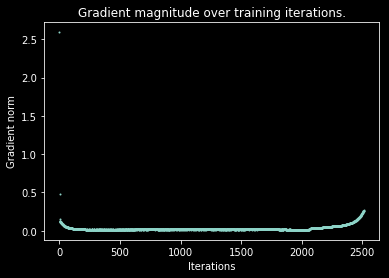

In [19]:
plt.scatter(iteration_vector, gradient_magnitude, s=1)
plt.title('Gradient magnitude over training iterations.')
plt.ylabel('Gradient norm')
plt.xlabel('Iterations')
plt.show()

Let's now visualize the training and validation loss.

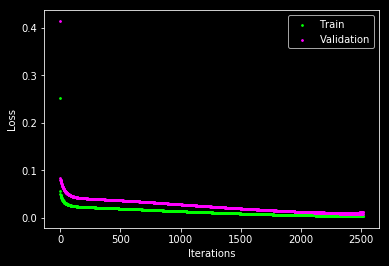

In [20]:
plt.close()
training_loss = mlp_sinc.training_loss
validation_loss = mlp_sinc.validation_loss
plt.scatter(iteration_vector, training_loss, s=3, c='lime', label='Train')
plt.scatter(iteration_vector, validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()

Let's try to see learnt function.

In [21]:
x_range = np.arange(-15,15, 0.05)
sinc_out = np.sin(x_range)/x_range
neuralnetwork_out = mlp_sinc.predict(x_range)

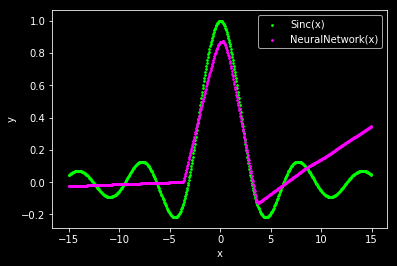

In [22]:
plt.scatter(x_range, sinc_out, s=3, c='lime', label='Sinc(x)')
plt.scatter(x_range, neuralnetwork_out, s=3, c='fuchsia', label='NeuralNetwork(x)')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='upper right')
plt.show()